<H1>10,000 USD worth of TKN invested in the Omnipool for one year</H1>

<H3>Effects of trade volume.</H3>
Trade volume generates fees, which are the primary way of offsetting IL. We'll assume prices do no change, so there is no impermanent loss. Trade volume goes from 0% to 2% of TVL per day. (So far we have observed ~1% on average.) We also assume 0.3% total fees. Due to the volume of data involved, the graph is actually formed by fully simulating one month and then extrapolating the results to one year. This should still be fairly accurate, because of the linear nature of the correlation between time and profit, but it does introduce a small amount of uncertainty.

In [4]:
import random
import sys
sys.path.append('../..')

from model import processing
from matplotlib import pyplot as plt

from model import run, plot_utils as pu
from model.amm.omnipool_amm import OmnipoolState, cash_out_omnipool, usd_price, lrna_price, value_assets, execute_remove_liquidity
from model.amm.agents import Agent
from model.amm.trade_strategies import omnipool_arbitrage, invest_all, price_sensitive_trading
from model.amm.global_state import GlobalState, fluctuate_prices, historical_prices, ArchiveState

# same seed, same parameters = same simulation result
random.seed(42)
price_list = processing.import_binance_prices(['BTC', 'ETH', 'DOT'], start_date='Jan 1 2023', days = 30)

assets = {
    'HDX': {'usd price': 0.05, 'weight': 0.10},
    'USD': {'usd price': 1, 'weight': 0.20},
    'BTC': {'usd price': price_list[0]['BTC'], 'weight': 0.10},
    'ETH': {'usd price': price_list[0]['ETH'], 'weight': 0.40},
    'DOT': {'usd price': 1, 'weight': 0.17},
    'TKN': {'usd price': 1, 'weight': 0.03}
}

lrna_price_usd = 1
initial_omnipool_tvl = 10000000
liquidity = {}
lrna = {}

for tkn, info in assets.items():
    liquidity[tkn] = initial_omnipool_tvl * info['weight'] / info['usd price']
    lrna[tkn] = initial_omnipool_tvl * info['weight'] / lrna_price_usd

initial_state = GlobalState(
    pools={
        'omnipool': OmnipoolState(
            tokens={
                tkn: {'liquidity': liquidity[tkn], 'LRNA': lrna[tkn]} for tkn in assets
            },
            asset_fee=0.0025,
            lrna_fee=0,
            withdrawal_fee=False
        )
    },
    agents = {
        'Trader': Agent(
            holdings={tkn: 10000000 for tkn in assets}
        ),
        'LP': Agent(
            holdings={'TKN': 10000},
            trade_strategy=invest_all('omnipool')
        ),
        # 'LP2': Agent(
        #     holdings={'DOT': 10000},
        #     trade_strategy=invest_all('omnipool')
        # )
    },
    external_market={tkn: assets[tkn]['usd price'] for tkn in assets},
    archive_all=False
)

# copy DOT prices for TKN
# for j, step in enumerate(price_list):     
#     step['TKN'] = step['DOT'] / price_list[0]['DOT']

In [9]:
time_steps = 219000  # int(7200 * 365 / 12)
volume_events = []
trade_volume = []
semi_final_state = []
final_state = []
# initial_state._evolve_function = historical_prices(price_list)
for i in range(5):
    initial_state.agents['Trader'].trade_strategy=price_sensitive_trading(
        pool_id='omnipool',
        max_volume_usd=1.65 * i,
        price_sensitivity=10
    ) if i > 0 else None
    events = run.run(initial_state, time_steps)
    
    trade_volume.append({tkn: (sum([event.pools['omnipool'].volume_out[tkn] * event.external_market[tkn] 
                                    / event.pools['omnipool'].liquidity[tkn] for event in events])
        / time_steps * 7200) for tkn in assets}
    )
    print('Trade volume per day as a fraction of TVL:', trade_volume[i])

    volume_events.append(events[::200])
    volume_events[-1].append(events[-1])
    
    del events

Starting simulation...
Execution time: 42.282 seconds.
Trade volume per day as a fraction of TVL: {'HDX': 0.0, 'USD': 0.0, 'BTC': 0.0, 'ETH': 0.0, 'DOT': 0.0, 'TKN': 0.0}
Starting simulation...
Execution time: 45.922 seconds.
Trade volume per day as a fraction of TVL: {'HDX': 7.721712058478256e-05, 'USD': 0.0007576275147206286, 'BTC': 25.148787191903676, 'ETH': 0.4596912646564797, 'DOT': 0.0009166227365982178, 'TKN': 0.004978545123360402}
Starting simulation...
Execution time: 45.678 seconds.
Trade volume per day as a fraction of TVL: {'HDX': 0.00015574336368770852, 'USD': 0.0015028036009165375, 'BTC': 51.4861193881495, 'ETH': 0.9115494465340751, 'DOT': 0.0018153983689646843, 'TKN': 0.009859476554592293}
Starting simulation...
Execution time: 43.363 seconds.
Trade volume per day as a fraction of TVL: {'HDX': 0.0002324028364840227, 'USD': 0.0022956224009681946, 'BTC': 76.80552149768843, 'ETH': 1.3874016659422124, 'DOT': 0.0027226256534754016, 'TKN': 0.015107392684884846}
Starting simula

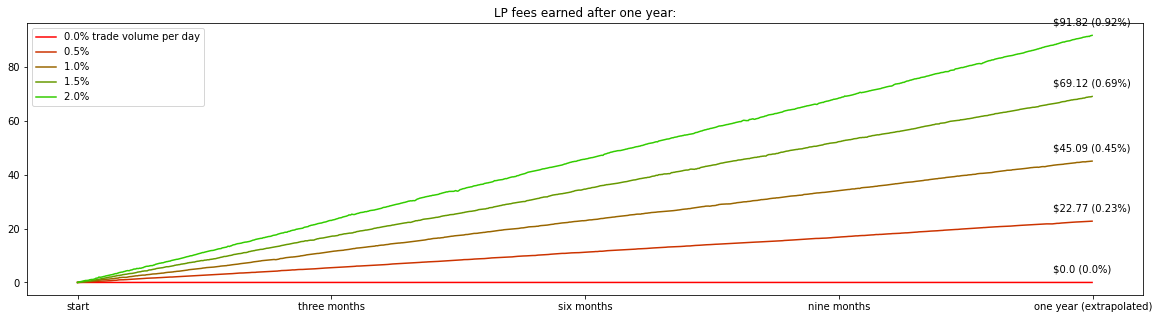

In [10]:
plt.figure(figsize=(20, 5))
plt.title('LP fees earned after one year:')
graph_length = len(volume_events[1])
plt.xticks(
    [0, graph_length / 4, graph_length / 2, graph_length * 3/4, graph_length],
    ['start', 'three months', 'six months', 'nine months', 'one year (extrapolated)']
)
colors = pu.color_gradient(length=5, color1=(255, 0, 0), color2=(0, 255, 0))
baseline =[value_assets(event.external_market, initial_state.agents['LP'].holdings) for event in volume_events[0]]
# [0] * len(volume_events[0])
# [cash_out_omnipool(event.pools['omnipool'], event.agents['LP'], event.external_market) for event in volume_events[0]]
volume_returns = [
    [
        (cash_out_omnipool(event.pools['omnipool'], event.agents['LP'], event.external_market)
        - baseline[i]) * 12  # extend to one year
        for i, event in enumerate(events)
    ]
    for events in volume_events
]

for i, scenario in enumerate(volume_returns):
    plt.plot(range(len(scenario)), scenario, color=colors[i])
    plt.annotate(
        f'${round(scenario[-1], 2)} ({round(scenario[-1] / 100, 2)}%)', 
        xy=(len(scenario), scenario[-1]), xytext=(-40, 10), textcoords='offset points'
    )

plt.legend([
    f'{round(volume["TKN"] * 100, 1)}% {("trade volume per day") if volume["TKN"] == 0 else ""}' 
    for volume in trade_volume
])


### 